In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
%matplotlib inline

In [7]:
os.chdir(r'C:\Users\alanw\OneDrive\Varsity\Research\Code')

In [8]:
# Loading  data
def import_data(type):
    if type == "Balanced":
        df = pd.read_csv('data_balanced_cv.csv')
    elif type == "Original":
        df = pd.read_csv('data_not_cleaned.csv')
    return df

In [9]:
# Loading  data
df = import_data("Balanced")

# Data Preparation

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Scaling Data

In [11]:
scaler = StandardScaler()

In [12]:
scaler.fit(df.drop('Y',axis=1))

StandardScaler()

In [13]:
scaled_features = scaler.fit_transform(df.drop('Y',axis=1))

Setting up datasets

In [14]:
X = pd.DataFrame(scaled_features,columns=df.columns[:-1]).values
y = df['Y'].values

In [15]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.05, random_state=69)

In [16]:
x, z = df['Y'].value_counts()
print("Data Split: " + str(int(x/(x+z)*100)) + ":" + str(int(z/(x+z)*100)))

Data Split: 52:47


# Setting Up and Training The Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [18]:
def create_network(nodes=30,init='normal'):

    # create model
    model = Sequential()
    
    # hidden layer
    model.add(Dense(nodes, input_dim=X.shape[1], kernel_initializer=init, activation='relu'))

    # output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
    # Return compiled network
    return model

# Gridsearch

In [19]:
# Wrap Keras model so it can be used by scikit-learn
ann = KerasClassifier(build_fn=create_network, verbose=0)

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
# define search space
param_grid = dict()
param_grid['epochs'] = [50, 100, 200]
param_grid['init'] = ['normal', 'uniform']
param_grid['nodes'] = [30, 15, 45, 60]

In [17]:
# define search
grid = GridSearchCV(ann, param_grid, scoring='accuracy', n_jobs=-1, cv=3)

In [18]:
t0 = datetime.now()
grid_results = grid.fit(X, y)
t1 = datetime.now()

In [19]:
# summarize results
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))
print("Execution Time: ", (t1 - t0))

Best: 0.738009 using {'epochs': 200, 'init': 'normal', 'nodes': 45}
Execution Time:  0:22:06.657606


# Crossvalidate

In [20]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate

In [21]:
def create_network():

    # create model
    model = Sequential()
    
    # hidden layer
    model.add(Dense(45, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))

    # output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
    # Return compiled network
    return model

In [22]:
# Wrap Keras model so it can be used by scikit-learn
best_ann = KerasClassifier(build_fn=create_network, epochs=100, verbose=0)

In [23]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=69)

In [24]:
t0 = datetime.now()
scores = cross_validate(ann, X, y, scoring=['accuracy','roc_auc','precision','recall','f1'], cv=cv, n_jobs=-1)
t1 = datetime.now()

In [25]:
print('Mean ROC AUC: %.2f%% Std Dev: (+/- %.3f%%)' % (np.mean(scores['test_accuracy']*100), np.std(scores['test_accuracy']*100)))
print('Mean ROC AUC: %.2f%% Std Dev: (+/- %.3f%%)' % (np.mean(scores['test_roc_auc']*100), np.std(scores['test_roc_auc']*100)))
print('Mean Precision: %.2f%% Std Dev: (+/- %.3f%%)' % (np.mean(scores['test_precision']*100), np.std(scores['test_precision']*100)))
print('Mean Recall: %.2f%% Std Dev: (+/- %.3f%%)' % (np.mean(scores['test_recall']*100), np.std(scores['test_recall']*100)))
print('Mean F1 Score: %.2f%% Std Dev: (+/- %.3f%%)' % (np.mean(scores['test_f1']*100), np.std(scores['test_f1']*100)))
print("Execution Time: ", (t1 - t0))

Mean ROC AUC: 70.86% Std Dev: (+/- 0.962%)
Mean ROC AUC: 76.14% Std Dev: (+/- 0.929%)
Mean Precision: 73.37% Std Dev: (+/- 1.266%)
Mean Recall: 60.80% Std Dev: (+/- 2.127%)
Mean F1 Score: 66.47% Std Dev: (+/- 1.398%)
Execution Time:  0:00:17.749716


### Final Evaluations

In [36]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, roc_curve, classification_report, auc
import pickle
import shap

In [24]:
t0 = datetime.now()
best_ann.fit(X,y, epochs=200,verbose=0)
t1 = datetime.now()
print("Training Time: ", (t1 - t0))

Training Time:  0:04:22.848084


In [25]:
predictions = best_ann.predict(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [33]:
confusion_matrix(y_test,predictions)

array([[572, 134],
       [189, 366]], dtype=int64)

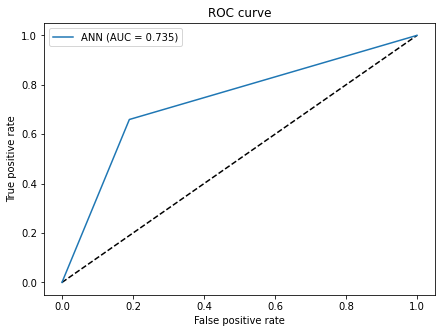

In [45]:
plt.figure(figsize=(7, 5))

predictions = best_ann.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predictions)

auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ANN (AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(r'C:\Users\alanw\OneDrive\Varsity\Research\Paper Itself\LaTeX\images\ann_roc.png')
plt.show()

In [47]:
kappa = cohen_kappa_score(y_test, predictions)
print("Cohen's Kappa: %.2f%%" % (kappa*100))

Cohen's Kappa: 47.47%


In [37]:
best_ann.save("ANN_Final.h5")

AttributeError: 'KerasClassifier' object has no attribute 'save'

In [48]:
import dill
dill.dump_session('ann_final.db')

TypeError: cannot pickle 'tensorflow.python._tf_stack.StackSummary' object

In [1]:
import dill
dill.load_session(r'C:\Users\alanw\OneDrive\Varsity\Research\Code\ann_final.db')

EOFError: Ran out of input